In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# epsilon은 데이터를 파괴?하는 정도를 지정하는 파라미터, 수치가 클수록 그 영향력이 커지다.
# 0을 넣어야 원본 상태를 볼 수 있기 떄문에 반드시 넣어야 한다.

epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "../../../Downloads/lenet_mnist_model.pth"
use_cuda = True

In [10]:
# 원본을 변형하는 세팅을 하기 전에, 우선 pretrained된 Lenet 모형을 불러온다.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10 , kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20 , kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # input dataset 사이즈를 알아야 이게 왜 320인지를 알텐데..ㄷㄷ
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 절반으로 줄이고..
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # 여기서 다시 한 번 절반으로 줄인다..
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)        

In [4]:
# MNINST 데이터를 불러오고 데이터를 로드하는 객체를 만든다.

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=1,
    shuffle=True
)

0it [00:00, ?it/s]

9920512it [00:03, 2975028.43it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 48121.00it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2396671.48it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 19581.74it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [5]:
# cuda setting
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
device

'cpu'

In [11]:
model = Net().to(device) # 모델을 device로 보내고
model.load_state_dict(torch.load(pretrained_model, map_location="cpu")) #pretrained model에서 파라미터 가지고 옴

<All keys matched successfully>

In [13]:
model.eval() # evaluation mode

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

#### Now we can define the function that creates the adversarial examples by perturbing the original inputs

In [19]:
def fgsm_attack(image, epsilon, data_grad):
    # collect the element-wise sign of the data gradient.
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixcel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

Finally, the central result of this tutorial comes from the test function. Each call to this function performs a full test step in the MNIST test set and reports a final accuracy. However, notice that this function also takes an epsilon input. This is because the test function reports the accuracy of a model that is under attack from adversary with strength e. More specifically, for each sample in test set, the function computes the gradient of the loss w.r.t the input data (data_grad), creates a perturbed image with fgsm_attack, then checks to see if the perturbed example is adversarial. In addition to testing the accuracy of the model, the function also saves and returns some successful adversarial examples to be visualized later.

In [37]:
def test(model, device, test_loader, epsilon):
    
    correct = 0
    adv_examples = []
    
    for data, target in test_loader:
        
        # 데이터와 모델을 이렇게 디바이스에 보내줘야 함
        data, target = data.to(device), target.to(device)
        # data도 gradient로 변형해줄 예정
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of max log-probability
        
        # if initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        
        # calcuate the loss
        loss = F.nll_loss(output, target)
        
        # Zero all exsiting gradients
        model.zero_grad()
        
        # calculate gradients of model in backward pass
        loss.backward()
        
        # Collect datagrad
        data_grad = data.grad.data 
        
        # Call FGSM Attack 
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Re_classify the perturbed image 
        output = model(perturbed_data)
        
        # Check for success 
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item(): # If it is correct,
            correct += 1
            # special case for saving 0 epsilon examples
            if (epsilon==0) and (len(adv_examples)<5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                    
    # calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print("Epsilon {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
        
    return final_acc, adv_examples

#### Run Attack

In [38]:
accuracies = []
examples = [] 

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon 0.3	Test Accuracy = 869 / 10000 = 0.0869


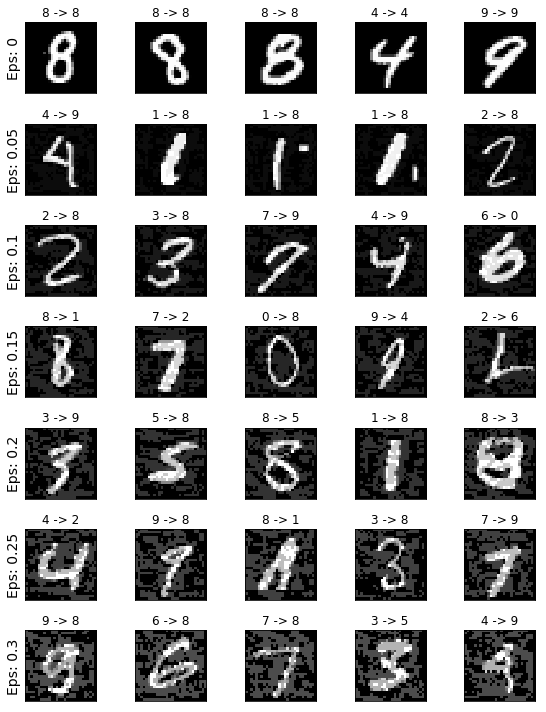

In [39]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()